In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats import RectifiedLogistic
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

""" Load """
dir_name = "physio"
subdir_pattern = ["*J_RCML_000*"]
dir = os.path.join(data.data_path, dir_name)

participants = range(1, 9)

df, mat, time = load_data(dir=dir, subdir_pattern=subdir_pattern, participants=participants)


""" Custom filter """
conditions = ["C5M-C5L", "C6M-C6L", "C7M-C7L", "C8M-C8L"]

idx = df.compound_position.isin(conditions)

df = df[idx].copy()
df.reset_index(drop=True, inplace=True)

mat = mat[idx, :, :]

""" Preprocess """
df, encoder_dict, mat = data.build(df=df, mat=mat)

2023-06-22 16:13:58,846 - hb_mep.utils.utils - INFO - func:load_data took: 1.67 sec
2023-06-22 16:13:58,887 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-22 16:13:58,919 - hb_mep.utils.utils - INFO - func:preprocess took: 0.03 sec
2023-06-22 16:13:58,919 - hb_mep.utils.utils - INFO - func:build took: 0.03 sec


#### Plot

2023-06-22 16:14:02,931 - hb_mep.utils.utils - INFO - func:plot took: 3.99 sec


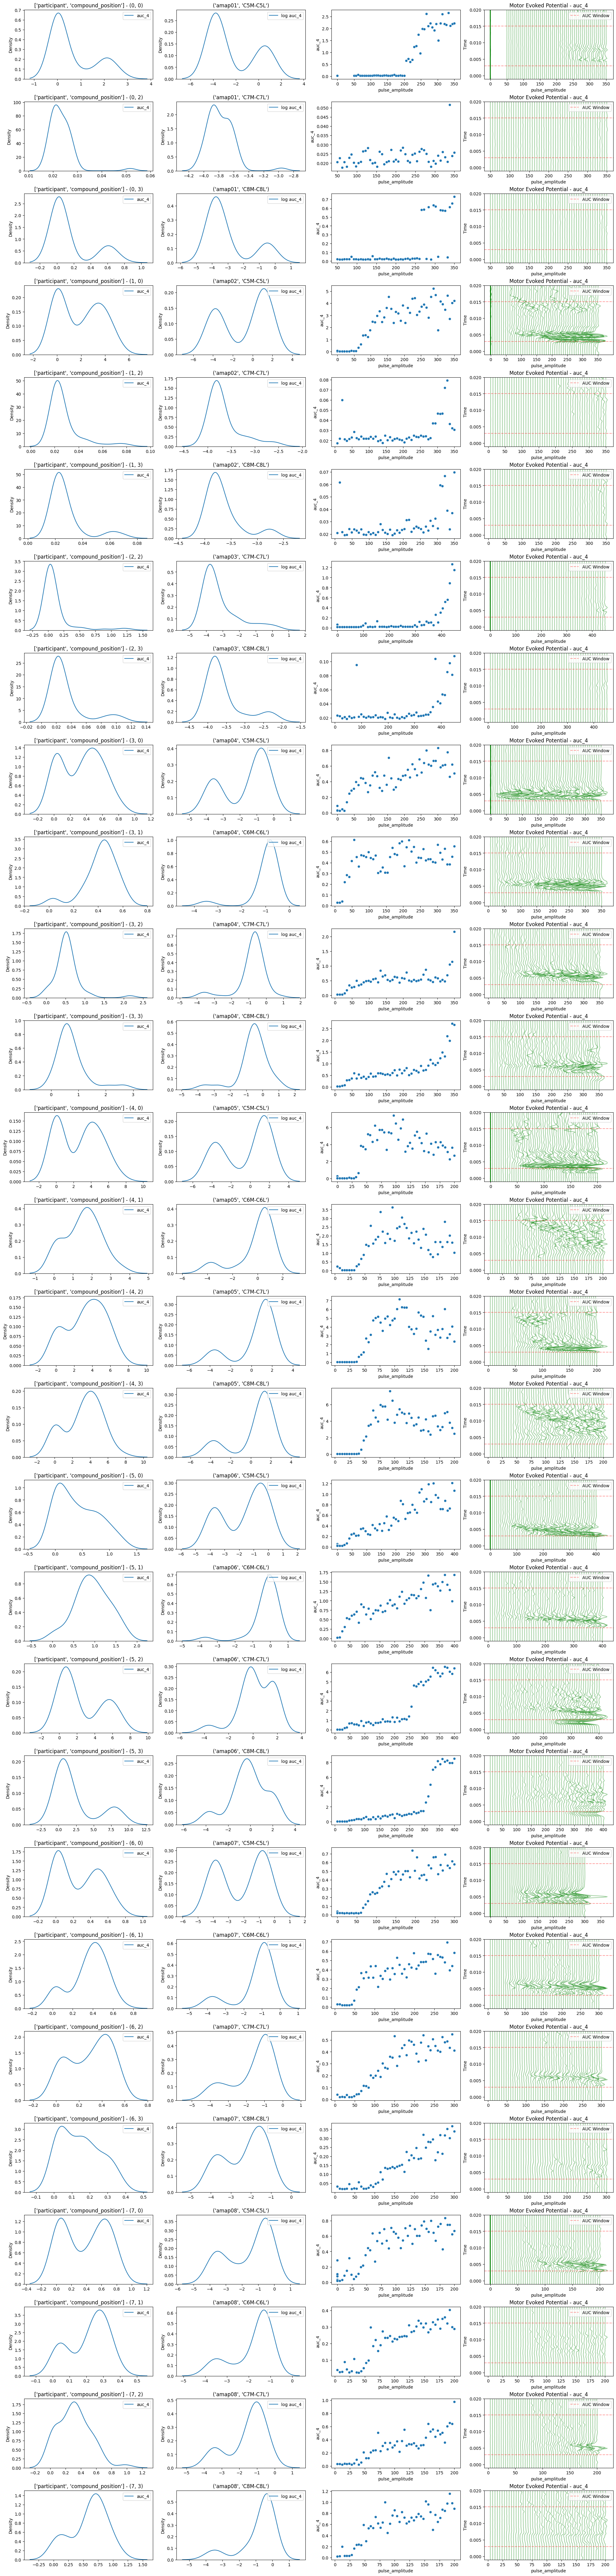

In [5]:
plot(df=df, encoder_dict=encoder_dict, mat=mat, time=time);

#### Initialize model

In [6]:
model = RectifiedLogistic(config)

2023-06-22 16:14:15,788 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-22 16:14:15,789 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-22 16:14:15,790 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-22 16:14:15,791 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-22 16:14:15,791 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-22 16:29:50,466 - hb_mep.utils.utils - INFO - func:run_inference took: 15 min and 34.60 sec


#### Diagnostics

In [8]:
mcmc.print_summary(prob=.95)


                               mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0,0]    199.96      0.77    199.96    198.54    201.68   5222.07      1.00
                 a[0,1,0]     55.63      1.84     55.48     52.46     59.73   4994.24      1.00
                 a[0,2,0]    246.37     85.00    257.67     55.43    392.67   5137.68      1.00
                 a[0,3,0]     20.91      2.35     21.13     16.54     25.16   2917.58      1.00
                 a[0,4,0]     31.74      1.72     31.44     28.96     35.42   3357.11      1.00
                 a[0,5,0]     14.75      4.02     15.18      6.41     22.10   6659.94      1.00
                 a[0,6,0]     59.23      1.05     59.21     57.17     61.61   8653.40      1.00
                 a[0,7,0]     29.97      5.19     30.75     18.37     38.83   1156.74      1.00
                 a[1,0,0]    211.56     71.40    214.83     45.81    341.74   2989.10      1.00
                 a[1,1,0]    180.57    

#### Plot fitted curves

In [10]:
model.plot(df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict, mat=mat, time=time);

2023-06-22 16:53:09,469 - hb_mep.utils.utils - INFO - func:plot took: 15 min and 8.75 sec


2023-06-18 18:04:44,601 - hb_mep.utils.utils - INFO - func:predictive_check took: 1 min and 41.50 sec


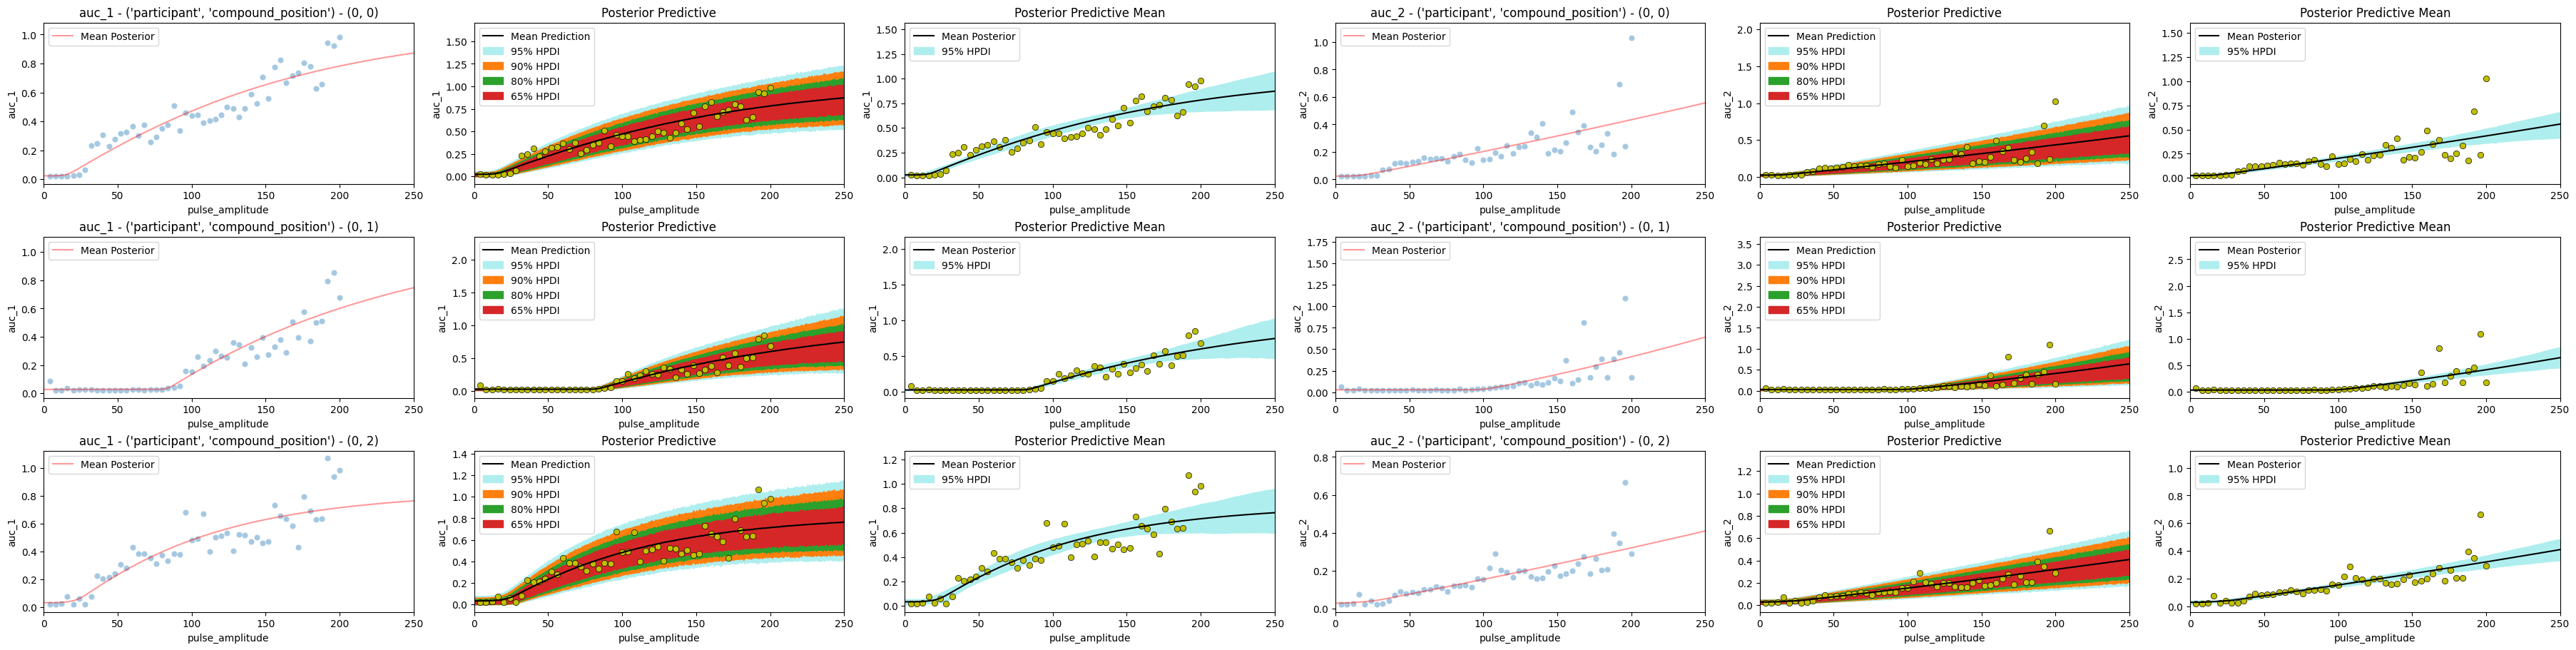

In [ ]:
model.predictive_check(df=df, posterior_samples=posterior_samples);